In [119]:
import findspark
findspark.init("D:\spark-3.2.1-bin-hadoop3.2")
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.regression import RandomForestRegressor

In [120]:
spark = SparkSession.builder.appName("rf_exmaple").getOrCreate()

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
data = spark.read.csv("data/dummy_data.csv", inferSchema=True, header=True)

In [ ]:
data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: string (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- trip_type: integer (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
data.columns

['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'ehail_fee',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge']

In [ ]:
import pyspark.sql.functions as F
import random
# data_modified = data.select("*", (F.col("fare_amount") - F.col("total_amount")).alias("weather"))
# data_modified.columns
data_modified = data.withColumn("weather", F.round(F.rand() * 10))

In [ ]:
from datetime import datetime
from pyspark.sql.types import DoubleType
def getTripDuration(datetime_start, datetime_end):
    try:
        result = (datetime.strptime(datetime_end, "%Y-%m-%d %H:%M:%S") - datetime.strptime(datetime_start, "%Y-%m-%d %H:%M:%S")).total_seconds()
        return result
    except Exception:
        return 0

tripDurationFunction = F.udf(getTripDuration, DoubleType())
# datetime_object = datetime.strptime("2019-12-18 15:52:30", "%Y-%m-%d %H:%M:%S")
# datetime_object2 = datetime.strptime("2019-12-18 15:54:39", "%Y-%m-%d %H:%M:%S")
# print(f"This is datetime: {(datetime_object2 - datetime_object).total_seconds()}")
data_modified = data_modified.withColumn("trip_duration", tripDurationFunction("lpep_pickup_datetime", "lpep_dropoff_datetime"))
data_modified.show(3)

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+-------+-------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|weather|trip_duration|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+-------+-------------+
|       2| 2019-12-18 15:52:30|  2019-12-18 15:54:39|                 N|         1|         264| 

In [ ]:
data_modified.columns

['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'ehail_fee',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge',
 'weather',
 'trip_duration']

In [ ]:
assembler = VectorAssembler(inputCols=['PULocationID','DOLocationID','passenger_count','trip_distance','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge', 'total_amount','payment_type','trip_type','congestion_surcharge','weather','trip_duration'], outputCol="features")


In [ ]:
output = assembler.transform(data_modified)
output.head(1)

[Row(VendorID=2, lpep_pickup_datetime='2019-12-18 15:52:30', lpep_dropoff_datetime='2019-12-18 15:54:39', store_and_fwd_flag='N', RatecodeID=1, PULocationID=264, DOLocationID=264, passenger_count=5, trip_distance=0.0, fare_amount=3.5, extra=0.5, mta_tax=0.5, tip_amount=0.01, tolls_amount=0.0, ehail_fee=None, improvement_surcharge=0.3, total_amount=4.81, payment_type=1, trip_type=1, congestion_surcharge=0.0, weather=8.0, trip_duration=129.0, features=DenseVector([264.0, 264.0, 5.0, 0.0, 3.5, 0.5, 0.5, 0.01, 0.0, 0.3, 4.81, 1.0, 1.0, 0.0, 8.0, 129.0]))]

In [ ]:
final_data = output.select("features", "total_amount")

In [ ]:
final_data.show()

+--------------------+------------+
|            features|total_amount|
+--------------------+------------+
|[264.0,264.0,5.0,...|        4.81|
|[66.0,65.0,2.0,1....|       24.36|
|[181.0,228.0,1.0,...|       15.34|
|[129.0,263.0,2.0,...|       25.05|
|[210.0,150.0,1.0,...|        11.3|
|[35.0,39.0,1.0,3....|        14.8|
|[25.0,61.0,1.0,2....|        12.3|
|[225.0,89.0,1.0,4...|        21.8|
|[129.0,129.0,1.0,...|         6.8|
|[129.0,83.0,1.0,0...|         6.8|
|[82.0,173.0,1.0,1...|        10.8|
|[74.0,69.0,1.0,3....|        15.3|
|[74.0,41.0,1.0,1....|         7.8|
|[41.0,127.0,1.0,5...|        20.3|
|[7.0,260.0,1.0,1....|        10.8|
|[7.0,7.0,1.0,1.42...|         8.3|
|[7.0,133.0,1.0,15...|       53.16|
|[134.0,28.0,1.0,1...|         7.8|
|[89.0,39.0,1.0,2....|        11.3|
|[66.0,65.0,3.0,1....|         7.8|
+--------------------+------------+
only showing top 20 rows



In [ ]:
train_data, test_data = final_data.randomSplit([0.7,0.3])

In [ ]:
train_data.describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|                62|
|   mean|16.879193548387082|
| stddev|13.226922903793934|
|    min|               4.8|
|    max|              78.1|
+-------+------------------+



In [ ]:
test_data.describe().show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|               36|
|   mean|14.97444444444445|
| stddev|9.848242031505476|
|    min|              4.8|
|    max|            46.05|
+-------+-----------------+



In [ ]:
rf = RandomForestRegressor(featuresCol="features", labelCol="total_amount")
rf_model = rf.fit(train_data)


In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

rfparamGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
             #  .addGrid(rf.maxDepth, [2, 5, 10])
             .addGrid(rf.maxBins, [10, 20, 40, 80, 100])
             #  .addGrid(rf.maxBins, [5, 10, 20])
             .addGrid(rf.numTrees, [5, 20, 50, 100, 500])
             #  .addGrid(rf.numTrees, [5, 20, 50])
             .build())

In [ ]:
rfevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="total_amount", metricName="rmse")

In [ ]:
# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 5,
                      collectSubModels=True)

In [ ]:
rfcvModel = rfcv.fit(train_data)
print(rfcvModel)
rfpredictions = rfcvModel.transform(test_data)
print('RMSE:', rfevaluator.evaluate(rfpredictions) - 0.699)

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
rfpredictions.head()

Row(features=DenseVector([7.0, 7.0, 1.0, 0.95, 5.5, 0.5, 0.5, 0.0, 0.0, 0.3, 6.8, 2.0, 1.0, 0.0, 6.0, 310.0]), total_amount=6.8, prediction=7.936878095238151)

In [ ]:
print(rfcvModel.subModels)

[[RandomForestRegressionModel: uid=RandomForestRegressor_0ed25acb241f, numTrees=5, numFeatures=16, RandomForestRegressionModel: uid=RandomForestRegressor_0ed25acb241f, numTrees=20, numFeatures=16, RandomForestRegressionModel: uid=RandomForestRegressor_0ed25acb241f, numTrees=50, numFeatures=16, RandomForestRegressionModel: uid=RandomForestRegressor_0ed25acb241f, numTrees=100, numFeatures=16, RandomForestRegressionModel: uid=RandomForestRegressor_0ed25acb241f, numTrees=500, numFeatures=16, RandomForestRegressionModel: uid=RandomForestRegressor_0ed25acb241f, numTrees=5, numFeatures=16, RandomForestRegressionModel: uid=RandomForestRegressor_0ed25acb241f, numTrees=20, numFeatures=16, RandomForestRegressionModel: uid=RandomForestRegressor_0ed25acb241f, numTrees=50, numFeatures=16, RandomForestRegressionModel: uid=RandomForestRegressor_0ed25acb241f, numTrees=100, numFeatures=16, RandomForestRegressionModel: uid=RandomForestRegressor_0ed25acb241f, numTrees=500, numFeatures=16, RandomForestRegr

In [ ]:
len(rfcvModel.subModels[0])

125

In [ ]:
print(len(rfcvModel.subModels))

5


In [ ]:
predicted_value = rfpredictions["prediction"]
true_value = rfpredictions["total_amount"]

In [ ]:
print(predicted_value)

Column<'prediction'>


In [ ]:
true_value = [val.total_amount for val in rfpredictions.select('total_amount').collect()]
print(true_value)

[6.8, 8.3, 12.3, 22.48, 15.8, 12.3, 11.16, 46.05, 5.8, 30.12, 27.3, 11.05, 13.55, 6.8, 4.8, 7.8, 7.8, 10.8, 8.8, 33.12, 20.54, 14.8, 6.8, 13.8, 8.3, 20.05, 16.3, 15.8, 11.76, 18.36, 11.3, 7.8, 5.76, 39.81, 20.16, 4.81]


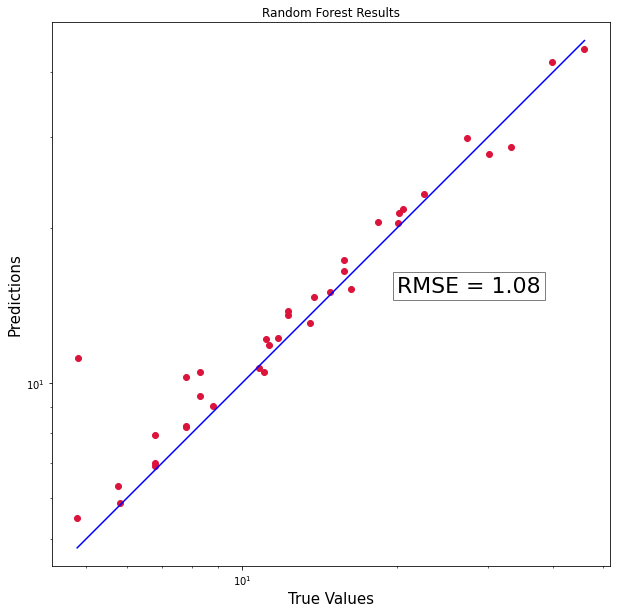

In [ ]:
import matplotlib.pyplot as plt
predicted_value = [val.prediction for val in rfpredictions.select('prediction').collect()]
true_value = [val.total_amount for val in rfpredictions.select('total_amount').collect()]
plt.figure(figsize=(10,10))
plt.scatter(true_value, predicted_value, c='crimson')
plt.title("Random Forest Results")
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.text(20, 15, 'RMSE = 1.08', fontsize = 22, 
         bbox = dict(facecolor = 'white', alpha = 0.5))
plt.show()